In [1]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [2]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [3]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [4]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [5]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [6]:
def without_news_LSTM(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]

  # LSTM Model
  # Setting the parameter  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=25, batch_size=32)

  plot_training_loss(hist)

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [7]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [8]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (390, 1)
Epoch 1/25
71/71 [==============================] - 7s 28ms/step - loss: 0.2906 - mean_squared_error: 0.2906
Epoch 2/25
71/71 [==============================] - 2s 29ms/step - loss: 0.0889 - mean_squared_error: 0.0889
Epoch 3/25
71/71 [==============================] - 2s 31ms/step - loss: 0.0776 - mean_squared_error: 0.0776
Epoch 4/25
71/71 [==============================] - 2s 30ms/step - loss: 0.0802 - mean_squared_error: 0.0802
Epoch 5/25
71/71 [==============================] - 2s 30ms/step - loss: 0.0814 - mean_squared_error: 0.0814
Epoch 6/25
71/71 [==============================] - 2s 29ms/step - loss: 0.0765 - mean_squared_error: 0.0765
Epoch 7/25
71/71 [==============================] - 2s 29ms/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 8/25
71/71 [==============================] - 2s 28ms/step - loss: 0.0738 - mean_squared_error: 0.0738
Epoch 9/25
71/71 [==============================] - 2s 30ms/s

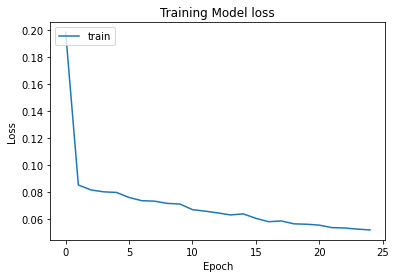

           date     Actual  Predicted
0    2018-07-27  47.023903  47.158919
1    2018-07-30  46.241833  47.064233
2    2018-07-31  45.982750  46.292980
3    2018-08-01  46.074760  46.185609
4    2018-08-02  48.789028  48.796802
..          ...        ...        ...
385  2020-02-07  80.486107  78.626923
386  2020-02-10  79.392090  78.548800
387  2020-02-11  79.769165  78.517585
388  2020-02-12  79.287888  78.189752
389  2020-02-13  81.170799  79.769123

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0521 - mean_squared_error: 0.0521
LSTM Model Loss =  [0.052110373973846436, 0.052110373973846436]
Model Accuracy =  99.0396079005609
Mean Absolute Error =  0.4967833754439306  degrees
Mean Squared Error =  0.48287771136220203
Root Mean Squared Error =  0.6948940288721742

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (390, 1)
Epoch 

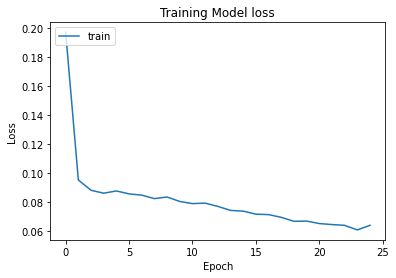

           date       Actual    Predicted
0    2018-07-27  1808.000000  1846.926567
1    2018-07-30  1817.270020  1847.365319
2    2018-07-31  1779.219971  1781.869392
3    2018-08-01  1777.439941  1787.440113
4    2018-08-02  1797.170044  1807.240553
..          ...          ...          ...
385  2020-02-07  2050.229980  1994.600276
386  2020-02-10  2079.280029  2014.173191
387  2020-02-11  2133.909912  2091.042920
388  2020-02-12  2150.800049  2086.632585
389  2020-02-13  2160.000000  2079.496041

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0534 - mean_squared_error: 0.0534
LSTM Model Loss =  [0.05336833745241165, 0.05336833745241165]
Model Accuracy =  98.88560780436195
Mean Absolute Error =  19.629698562499975  degrees
Mean Squared Error =  723.0336822871975
Root Mean Squared Error =  26.889285641072682

--------------------------------------------------------------------------

Evaluating Model for Company

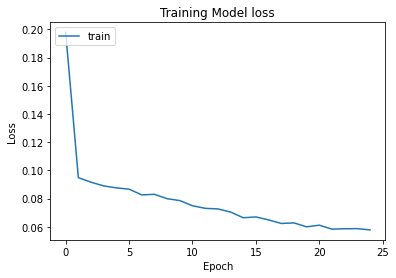

           date     Actual  Predicted
0    2018-07-27  43.653885  43.360602
1    2018-07-30  43.562386  43.378016
2    2018-07-31  43.324490  43.385631
3    2018-08-01  44.157127  44.051825
4    2018-08-02  44.019875  44.007951
..          ...        ...        ...
385  2020-02-07  44.165833  43.420188
386  2020-02-10  43.906483  43.359725
387  2020-02-11  43.877670  43.318299
388  2020-02-12  44.300312  43.363044
389  2020-02-13  44.155090  43.742372

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0559 - mean_squared_error: 0.0559
LSTM Model Loss =  [0.05587363243103027, 0.05587363243103027]
Model Accuracy =  99.21989889079663
Mean Absolute Error =  0.31872092935531604  degrees
Mean Squared Error =  0.16478091996750657
Root Mean Squared Error =  0.40593216178015085

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (390, 1)
Epoch

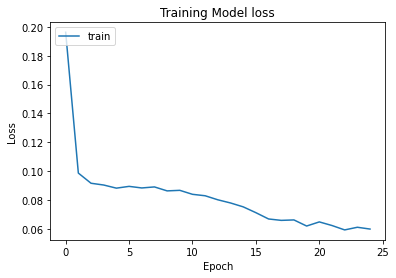

           date       Actual    Predicted
0    2018-07-27  1268.329956  1254.934647
1    2018-07-30  1238.500000  1250.192558
2    2018-07-31  1219.739990  1248.509057
3    2018-08-01  1217.260010  1243.900251
4    2018-08-02  1220.010010  1241.799033
..          ...          ...          ...
385  2020-02-07  1476.229980  1476.122040
386  2020-02-10  1479.229980  1474.147024
387  2020-02-11  1508.680054  1504.971670
388  2020-02-12  1508.790039  1501.288524
389  2020-02-13  1518.270020  1506.367655

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0602 - mean_squared_error: 0.0602
LSTM Model Loss =  [0.06020262837409973, 0.06020262837409973]
Model Accuracy =  99.11332695870146
Mean Absolute Error =  10.380718551874466  degrees
Mean Squared Error =  205.59618819772155
Root Mean Squared Error =  14.338625742996486

--------------------------------------------------------------------------

Evaluating Model for Compan

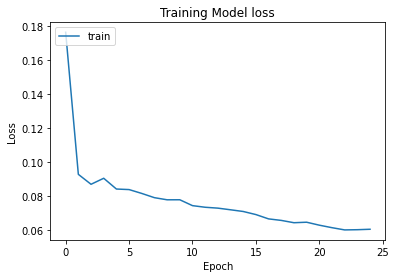

           date     Actual  Predicted
0    2018-07-27  33.331360  33.716900
1    2018-07-30  32.731140  34.208863
2    2018-07-31  32.595608  34.761043
3    2018-08-01  32.382629  35.514774
4    2018-08-02  32.034122  32.083760
..          ...        ...        ...
385  2020-02-07  37.343075  36.652425
386  2020-02-10  35.574196  36.659979
387  2020-02-11  35.397308  36.540257
388  2020-02-12  35.810051  36.406027
389  2020-02-13  36.507778  36.142832

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0569 - mean_squared_error: 0.0569
LSTM Model Loss =  [0.056887343525886536, 0.056887343525886536]
Model Accuracy =  99.07096945171936
Mean Absolute Error =  0.31392367788517106  degrees
Mean Squared Error =  0.2225558789086516
Root Mean Squared Error =  0.47175828440913636

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (390, 1)
Epoch

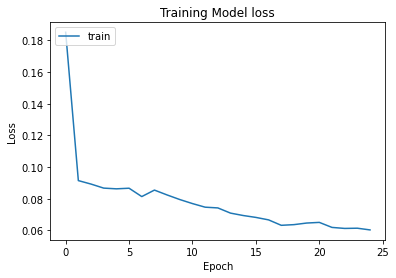

           date     Actual  Predicted
0    2018-07-27  71.726852  71.427814
1    2018-07-30  69.751480  71.570749
2    2018-07-31  69.598213  71.490707
3    2018-08-01  69.402374  71.371978
4    2018-08-02  68.448746  68.459677
..          ...        ...        ...
385  2020-02-07  56.346684  56.572440
386  2020-02-10  55.973351  56.135327
387  2020-02-11  55.382210  56.483238
388  2020-02-12  55.908691  56.640637
389  2020-02-13  56.592194  57.109384

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0535 - mean_squared_error: 0.0535
LSTM Model Loss =  [0.05350131168961525, 0.05350131168961525]
Model Accuracy =  99.31775818932728
Mean Absolute Error =  0.44913090359489627  degrees
Mean Squared Error =  0.39080532091745374
Root Mean Squared Error =  0.6251442400898002

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (390, 1)
Epoch 1

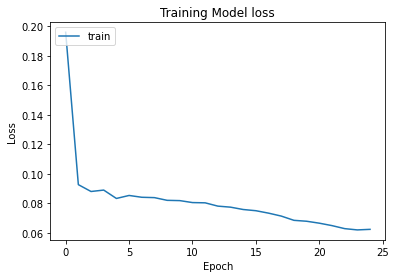

           date     Actual  Predicted
0    2018-07-27  63.071827  62.308076
1    2018-07-30  62.687599  62.245532
2    2018-07-31  62.601139  62.535143
3    2018-08-01  62.956558  62.459162
4    2018-08-02  62.226517  62.386521
..          ...        ...        ...
385  2020-02-07  88.100525  87.213446
386  2020-02-10  86.525017  86.790836
387  2020-02-11  86.948433  86.812275
388  2020-02-12  87.805115  86.896175
389  2020-02-13  87.430931  86.894788

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0725 - mean_squared_error: 0.0725
LSTM Model Loss =  [0.07250747084617615, 0.07250747084617615]
Model Accuracy =  99.13277978330193
Mean Absolute Error =  0.6503025780802887  degrees
Mean Squared Error =  0.7696432846823994
Root Mean Squared Error =  0.8772931577770338

--------------------------------------------------------------------------



In [10]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = without_news_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)


In [14]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.496783,0.482878,99.039608,0.694894
1,AMZN,19.629699,723.033682,98.885608,26.889286
2,ADM,0.318721,0.164781,99.219899,0.405932
3,GOOG,10.380719,205.596188,99.113327,14.338626
4,EBAY,0.313924,0.222556,99.070969,0.471758
5,XOM,0.449131,0.390805,99.317758,0.625144
6,ABT,0.650303,0.769643,99.132780,0.877293


In [17]:
# Mean Accuracy for With news
mean_results = company_results.mean(axis = 0)
mean_results

MAE           4.605611
MSE         132.951505
Accuracy     99.111421
RMSE          6.328990
dtype: float64

In [20]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P1_LSTM_All_Companies_without_news"+current_time+".csv"
company_results.to_csv(name)